Model loaded succeed


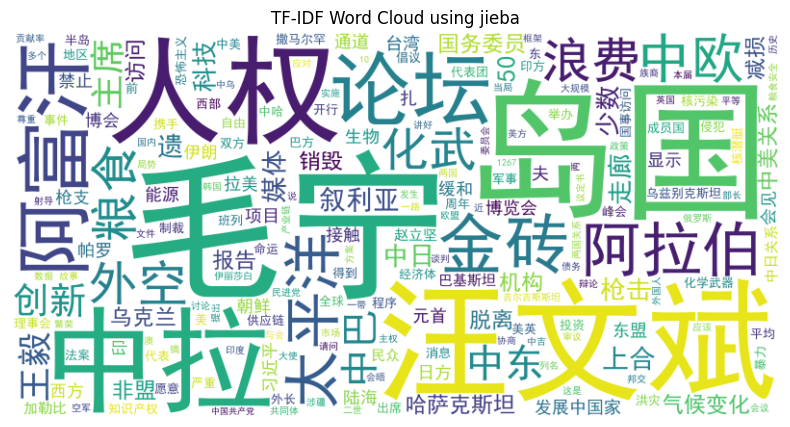

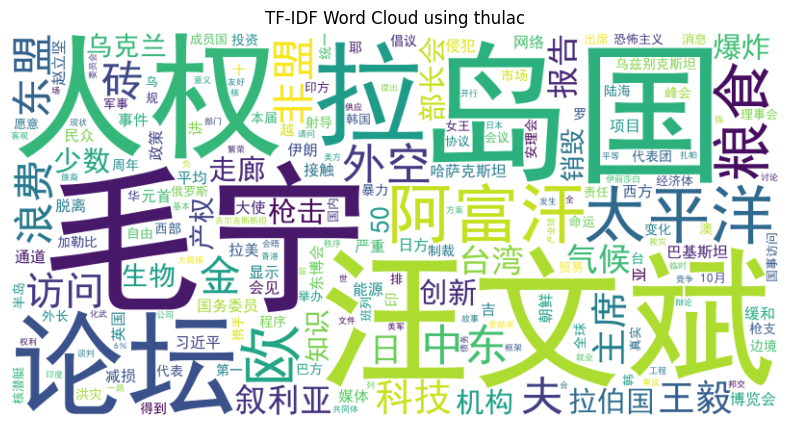

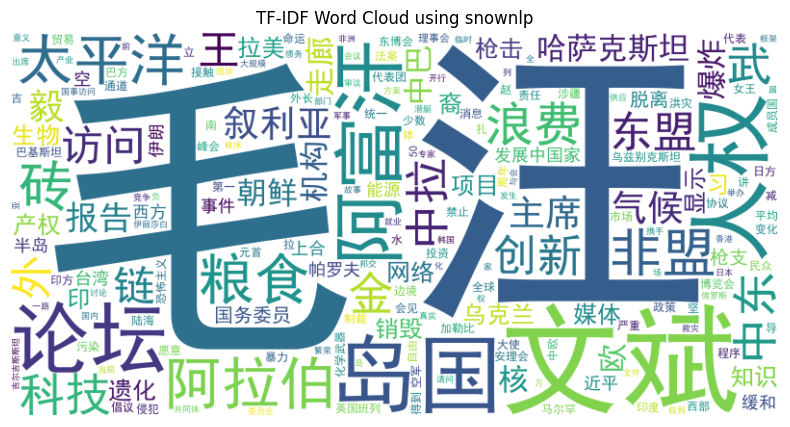

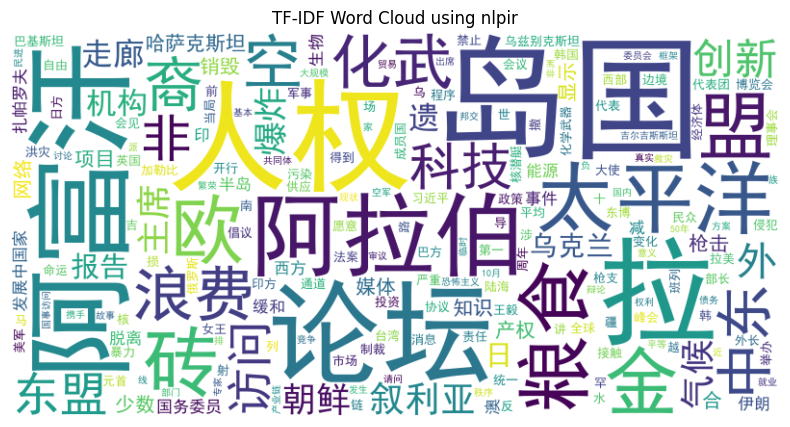

In [3]:
import os
import jieba
import thulac
import snownlp
import pynlpir
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import re

# 初始化NLPIR
pynlpir.open()

# 读取停用词
def read_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords

# 读取文本文件
def read_text_files(directory):
    texts = []
    for i in range(1, 21):
        file_path = os.path.join(directory, f'{i}.txt')
        with open(file_path, 'r', encoding='utf-8') as f:
            texts.append(f.read())
    return texts

# 分词函数
def jieba_tokenize(text, stopwords):
    words = jieba.lcut(text)
    return [word for word in words if word not in stopwords and re.match(r'\w+', word)]

def thulac_tokenize(text, stopwords, thulac_obj):
    words_with_pos = thulac_obj.cut(text, text=True).split()
    words = [word.split('_')[0] for word in words_with_pos]
    return [word for word in words if word not in stopwords and re.match(r'\w+', word)]

def snownlp_tokenize(text, stopwords):
    words = snownlp.SnowNLP(text).words
    return [word for word in words if word not in stopwords and re.match(r'\w+', word)]

def nlpir_tokenize(text, stopwords):
    words = pynlpir.segment(text, pos_tagging=False)
    return [word for word in words if word not in stopwords and re.match(r'\w+', word)]

# 计算词频
def calculate_tf(word_list):
    tf = defaultdict(int)
    for word in word_list:
        tf[word] += 1
    total_words = len(word_list)
    return {word: count / total_words for word, count in tf.items()}

# 计算IDF
def calculate_idf(doc_word_lists):
    N = len(doc_word_lists)
    idf = defaultdict(float)
    for doc in doc_word_lists:
        unique_words = set(doc)
        for word in unique_words:
            idf[word] += 1
    for word in idf:
        idf[word] = math.log(N / (idf[word] + 1))
    return idf

# 计算TF-IDF
def calculate_tf_idf(tf, idf):
    tf_idf = {word: tf[word] * idf[word] for word in tf}
    return tf_idf

# 绘制词云
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(font_path='simhei.ttf', width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 主函数
def main():
    directory = 'D:\\code\\natural_language_processing\\lab2\\dataset'
    stopwords_file = 'D:\\code\\natural_language_processing\\lab1\\cn_stopwords.txt'
    stopwords = read_stopwords(stopwords_file)
    texts = read_text_files(directory)

    thulac_obj = thulac.thulac()

    tokenizers = {
        'jieba': jieba_tokenize,
        'thulac': thulac_tokenize,
        'snownlp': snownlp_tokenize,
        'nlpir': nlpir_tokenize
    }

    all_doc_word_lists = defaultdict(list)
    for tokenizer_name, tokenizer_func in tokenizers.items():
        for text in texts:
            if tokenizer_name == 'thulac':
                words = tokenizer_func(text, stopwords, thulac_obj)
            else:
                words = tokenizer_func(text, stopwords)
            all_doc_word_lists[tokenizer_name].append(words)

    idfs = {tokenizer_name: calculate_idf(doc_word_lists) for tokenizer_name, doc_word_lists in all_doc_word_lists.items()}

    for tokenizer_name, doc_word_lists in all_doc_word_lists.items():
        tf_idfs = []
        for words in doc_word_lists:
            tf = calculate_tf(words)
            tf_idf = calculate_tf_idf(tf, idfs[tokenizer_name])
            tf_idfs.append(tf_idf)

        combined_tf_idf = defaultdict(float)
        for tf_idf in tf_idfs:
            for word, score in tf_idf.items():
                combined_tf_idf[word] += score

        plot_wordcloud(combined_tf_idf, f'TF-IDF Word Cloud using {tokenizer_name}')

if __name__ == '__main__':
    main()